# Objective

This project will be an open-ended investigation into the dataset you chose for project 3; you will pose a prediction problem and train a model to solve it. You will follow the steps given below:

1. Explore the NBA datasets available on: basketball-reference.com.
1. Clearly state and frame a classification problem to find an accurate solution for.
1. Train a "baseline" model with generic set of features created for different kinds of data (e.g. ordinal encoding, one-hot encoding).
1. Engineer at least two new features from the data that improve your baseline model.
1. Create an `sklearn` ML-pipeline; do a search for the best model and parameters using the pipeline.
1. Do an inference analysis on the results (i.e. does my model perform better on attribute X vs Y?).

In [167]:
%matplotlib inline
import pandas as pd
import numpy as np
import util
import os

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

---
# Summary of Findings


## Introduction
---
State the prediction problem you are attempting, if it's a classification or regression problem, explain your choice of target variable and evaluation metric (objective).

Our classification problem we attempted was determining if NBA players were going to underperform or not during the playoffs. We chose our target variable to be called "Underperformed" which took on the value of a 1 or a 0. We had to engineer this target variable by first, defining 'underperformance' as a player having lower statistics during their playoffs compared to the league. We decided to work with the following statistics: '3P%', '2P%', and 'eFG%'. We chose to use statistics that were percents becasue the other statistics were running totals. Since there are less playoff games compared to league games, these statistics could not be as easily caculated to scale. Additionally, using domain knowledge, the difference of we decided to account for some deviation in "underperformance"; becasue, for example, a 1% difference in FG% or 3P% is not really considered an "underperformance". Therefore, we allowed our for the difference in league and playoff statistics chosen for the model to differ by 10%. The object of our model is to classify underperformance with high accuracy.


### Results: Baseline Model
---
A summary of the baseline model:
The number of features, including how many are quantitative, ordinal, and nominal.
The model performance (your evaluation metric) and whether you think this it's good or not (and why).

We designed a model with the following features: 
Quantitative columns: Untouched
Ordinal Columns: none
Nominal Columns:none

We chose to use KNeighborsClassifier() as the estimator for our baseline.

### Results: Final Model
---
A summary of the improved model:
The features you added and why they are good for your data.
The model type you chose; the parameters that ended up performing best; the method of model selection used.

After training the baseline model, we got an accuracy of around .8 (or 80 percent). We then ran a GridSearchCV onto our data and then got an accuracy score of .85. With the KNNeighbors classification, we felt like this accuracy score was fairly good and inline with our results that we got from our baseline model. We ran the best parameters and got n neighbors of 18, uniform weights and Manhattan for matrics. With our score of around .8 and a standard deviation average of around .015, we feel like our model is fairly accurate. 

Analysis: We mainly tried our model on two different classifications. We originally did our classification based on a Decision Tree Classifier. With this model, we kept getting an accuracy score of 1.0. Although that may sound great, we knew that consistently having an accuracy score of 1.0 meant that we were overfitting the model, which is definitely not a good thing. We then changed our model to the KNNeighbors Classification, and with that, we then consistently got an accuracy score of .8. With this, we feel like it would be a better model as it fits the model well, but is not consistently overfitted like the Decision Tree Classifier.  


### Results: Fairness Evaluation
---
Evaluate your model for "fairness" on an interesting subset of the data using a permutation test. Justify the parity measure you are using.

---

## Baseline Model
---

Since all of our statistics we used in our baseline model were quantatitative, we did not need to use an OrdinalEncoder() or OneHotEncoder().

In [170]:
nba = pd.read_csv('data/combined.csv')
# load cleaned csv from project3
nba = nba.drop(['Unnamed: 0', 'Pos_playoff', 'Age_playoff', 'Tm_playoff'], axis=1).rename(columns={'Pos_league': 'Pos', 'Age_league': 'Age', 'Tm_league': 'Tm'})
data = nba.copy()
data.head()

,Player,Pos,Age,Tm,G_league,GS_league,MP_league,FG_league,FGA_league,FG%_league,...,ORB_playoff,DRB_playoff,TRB_playoff,AST_playoff,STL_playoff,BLK_playoff,TOV_playoff,PF_playoff,PTS_playoff,Year
0,Jeff Adrien,PF,25.0,HOU,8.0,0.0,63.0,7.0,16.0,0.438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
1,Arron Afflalo,SG,26.0,DEN,62.0,62.0,2086.0,329.0,699.0,0.471,...,5.0,20.0,25.0,19.0,5.0,2.0,9.0,14.0,76.0,2012
2,Blake Ahearn,PG,27.0,UTA,4.0,0.0,30.0,4.0,14.0,0.286,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,2012
3,Solomon Alabi,C,23.0,TOR,14.0,0.0,122.0,13.0,36.0,0.361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
4,Cole Aldrich,C,23.0,OKC,26.0,0.0,173.0,22.0,42.0,0.524,...,5.0,8.0,13.0,0.0,0.0,0.0,0.0,3.0,10.0,2012


In [171]:
# creating the target variable using the statistics based on percents

all_league = ['3P%_league', '2P%_league', 'eFG%_league']

all_playoff = ['3P%_playoff', '2P%_playoff', 'eFG%_playoff']

def perf(d):    
    d['%UnderPerformed'] = pd.DataFrame(d[all_playoff].values - d[all_league].values).mean(axis=1, skipna=True)
    d['UnderPerformed'] = d['%UnderPerformed'].apply(lambda x: np.NaN if str(x) == 'nan' else (1 if x < -0.1 else 0))
    return d
perf(data).head()

,Player,Pos,Age,Tm,G_league,GS_league,MP_league,FG_league,FGA_league,FG%_league,...,TRB_playoff,AST_playoff,STL_playoff,BLK_playoff,TOV_playoff,PF_playoff,PTS_playoff,Year,%UnderPerformed,UnderPerformed
0,Jeff Adrien,PF,25.0,HOU,8.0,0.0,63.0,7.0,16.0,0.438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,NaN,NaN
1,Arron Afflalo,SG,26.0,DEN,62.0,62.0,2086.0,329.0,699.0,0.471,...,25.0,19.0,5.0,2.0,9.0,14.0,76.0,2012,-0.107667,1.0
2,Blake Ahearn,PG,27.0,UTA,4.0,0.0,30.0,4.0,14.0,0.286,...,0.0,2.0,0.0,0.0,0.0,0.0,5.0,2012,0.451333,0.0
3,Solomon Alabi,C,23.0,TOR,14.0,0.0,122.0,13.0,36.0,0.361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,NaN,NaN
4,Cole Aldrich,C,23.0,OKC,26.0,0.0,173.0,22.0,42.0,0.524,...,13.0,0.0,0.0,0.0,0.0,3.0,10.0,2012,-0.080000,0.0


Because the missingness in the nba dataset is NMAR, dropping the NaN values does not affect the model. The NaN values dropped were from players who either did not make the playoffs, or who did not make any shot attempts in the columns used in our model.

In [172]:
# keep only the columns used in our model
drop = ['Player', 'Pos', 'Age', 'Tm', 'G_league', 'GS_league', 'MP_league',
       'FG_league', 'FGA_league', 'FG%_league', '3P_league', '3PA_league',
       '2P_league', '2PA_league', 'FT_league', 'FTA_league', 'FT%_league', 
       'PF_league', 'G_playoff', 'GS_playoff', 'MP_playoff',
       'FG_playoff', 'FGA_playoff', 'FG%_playoff', '3P_playoff', '3PA_playoff',
       '2P_playoff', '2PA_playoff', '2P%_playoff','FT_playoff', 'FTA_playoff', 'FT%_playoff',
       'PF_playoff','Year']

data = perf(data)
data = data.dropna() # cant pass NaN values into pipeline

X = data.drop(columns=drop + ['UnderPerformed'], axis=1)
y = data.UnderPerformed

pl = Pipeline([('dt', KNeighborsClassifier())])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pl.fit(X_train, y_train)
print ("Accuracy: %s" % pl.score(X_test, y_test))

Accuracy: 0.7957446808510639


For our baseline model, we did not specify any n_neighbors or other parameters. This high accuracy may be the result of overfitting. In the next section we will modify our model to not only improve the accuracy, but also the robustness (i.e. correctly representing the process of interest).

In [214]:
pl.steps

[('dt',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=5, p=2,
             weights='uniform'))]

## Improvements

Using domain knowledge and looking closer at the distribution of the minutes played in league, we wanted to see if only including player statistics if the player played an average of 865 minutes. We picked this number (the 15th percentile) because the distribution of minutes played was relatively similar 0-25th percentile and we didnt want to get rid of too much of our data.

In [208]:
q75, q25 = np.percentile(data.MP_league, [75 ,15])
iqr = q75 - q25
q25

865.0999999999999

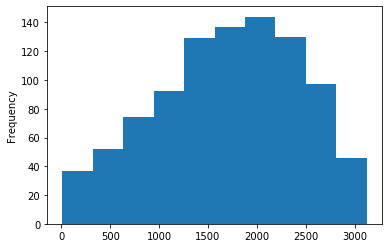

In [209]:
data.MP_league.plot(kind='hist')

In [210]:
# add minimum minutes played
data['min_minutes'] = ((((data['MP_league'] / data['G_league']) + (data['MP_playoff'] / data['G_playoff'])) / 2) > q25).replace({True: 1, False:0})

We also decided to see if dropping players who only played one season would improve our model.

In [211]:
# get rid of players who only played one season
s = data.Player.value_counts() == 1
new = data.set_index('Player', drop=False)
new = data.loc[[True for name in new.Player if name in s]]

## Final Model
---

For our final model, we used the improved model and did a search (using Grid Search) for the best model and parameters using the KNNClassifier().

In [212]:
from sklearn.model_selection import GridSearchCV

In [204]:
new = new.dropna()
X = new.drop(columns=drop + ['UnderPerformed'], axis=1)
y = new.UnderPerformed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [215]:
# How many combinations are there to search through?

parameters = {
    'n_neighbors': [2,4,5,6,7,9,10,11,12,13,14,15,18,19], 
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan']
}
clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
clf.fit(X_train, y_train)
clf.best_params_

{'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'uniform'}

In [216]:
clf_best = clf.best_estimator_
clf_best

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform')

We found that the best patameter was: {'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'uniform'}.
But was the "best parameter" the only "best choice"?

Below we ploted the histogram of scores across all models.As you can see there were a lot of models that had relatively accuracy. These high values imply there are actually many good model choices; and our model is robust.

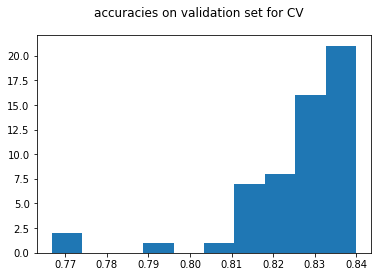

In [217]:
# Each x-value is the score of a different model, corresponding to a choice of parameters

plt.hist(clf.cv_results_['mean_test_score'])
plt.suptitle('accuracies on validation set for CV');

We also plotted the histogram of standard deviations for the CVs. As you can see there were also many small numbers, implying most parameters give stable models.

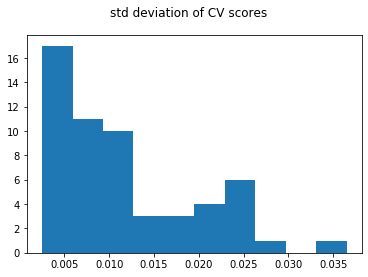

In [218]:
# Each x-value is the standard deviation for the 5-fold CV for a single model, corresponding to a choice of parameters
plt.hist(clf.cv_results_['std_test_score'])
plt.suptitle('std deviation of CV scores');

## Fairness Evaluation
---

In [162]:
# Evaluate your model for "fairness" on an interesting subset of the data using a permutation test. 
# Justify the parity measure you are using.
from sklearn import metrics

In [222]:
perm_data = data.copy()
perm_data.Pos.value_counts()

SG       262
PG       226
SF       198
PF       168
C         73
SF-SG      3
SG-PG      3
SG-SF      2
PF-C       2
PG-SG      1
Name: Pos, dtype: int64

To evaluate our model for fairness, we chose to test demographic parity. After looking at the distribution of 'Position' in the NBA dataset, we noticed that there was an uneven distribution. We chose to run a permutation test to see if the proportion of the population for which a player is classified as 'underperforming'  is the same both within the group, players of position 'PF' (Power Forward), and outside the group.

In [224]:
perm_data['isPF'] = perm_data['Pos'].apply(lambda x: 1 if x == 'PF' else 0)
perm_data.head()

,Player,Pos,Age,Tm,G_league,GS_league,MP_league,FG_league,FGA_league,FG%_league,...,STL_playoff,BLK_playoff,TOV_playoff,PF_playoff,PTS_playoff,Year,%UnderPerformed,UnderPerformed,min_minutes,isPF
1,Arron Afflalo,SG,26.0,DEN,62.0,62.0,2086.0,329.0,699.0,0.471,...,5.0,2.0,9.0,14.0,76.0,2012,-0.107667,1.0,0,0
7,Ray Allen*,SG,36.0,BOS,46.0,42.0,1565.0,226.0,493.0,0.458,...,17.0,2.0,17.0,41.0,192.0,2012,-0.064000,0.0,0,0
8,Tony Allen,SG,30.0,MEM,58.0,57.0,1525.0,210.0,448.0,0.469,...,9.0,7.0,10.0,21.0,48.0,2012,-0.138333,1.0,0,0
14,James Anderson,SG,22.0,SAS,51.0,2.0,603.0,66.0,174.0,0.379,...,1.0,0.0,0.0,1.0,11.0,2012,0.100000,0.0,0,0
15,Ryan Anderson,PF,23.0,ORL,61.0,61.0,1964.0,332.0,757.0,0.439,...,3.0,2.0,9.0,22.0,48.0,2012,-0.115333,1.0,0,1


In [239]:
PF = perm_data[perm_data['isPF'] == 1]
nPF = perm_data[perm_data['isPF'] == 0]

In [242]:
X = PF.drop(columns=drop + ['UnderPerformed'], axis=1)
y = PF.UnderPerformed

pl = Pipeline([('dt', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform'))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pl.fit(X_train, y_train)
print ("Accuracy: %s" % pl.score(X_test, y_test))

Accuracy: 0.7619047619047619


In [243]:
X = nPF.drop(columns=drop + ['UnderPerformed'], axis=1)
y = nPF.UnderPerformed

pl = Pipeline([('dt', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform'))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pl.fit(X_train, y_train)
print ("Accuracy: %s" % pl.score(X_test, y_test))

Accuracy: 0.8186528497409327


## Inference Analysis:
We chose to test demographic parity because of the distribution of player position. Our permutation test shows that there is no significant difference in the model performance on the different groups, as you can see in the similar accuracy scores.

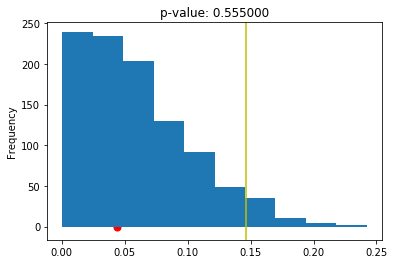

In [238]:
tvds.plot(kind='hist', title='p-value: %f' % pval)
plt.scatter([obs], [0], s=50, color='r')

perc = np.percentile(tvds, 95) # 5% significance level
plt.axvline(x=perc, color='y');

# NBA Playoffs
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Will a player/team make the playoffs this season? (try training on previous year!)
    * Predict players' "playoff performance" based on the regular statistics.
    * Guess the number of games a team will win in a season based on player statistics (need to aggregate statistics to a team-level).


Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

In [167]:
%matplotlib inline
import pandas as pd
import numpy as np
import util
import os

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

---
# Summary of Findings


## Introduction
---
State the prediction problem you are attempting, if it's a classification or regression problem, explain your choice of target variable and evaluation metric (objective).

Our classification problem we attempted was determining if NBA players were going to underperform or not during the playoffs. We chose our target variable to be called "Underperformed" which took on the value of a 1 or a 0. We had to engineer this target variable by first, defining 'underperformance' as a player having lower statistics during their playoffs compared to the league. We decided to work with the following statistics: '3P%', '2P%', and 'eFG%'. We chose to use statistics that were percents becasue the other statistics were running totals. Since there are less playoff games compared to league games, these statistics could not be as easily caculated to scale. Additionally, using domain knowledge, the difference of we decided to account for some deviation in "underperformance"; becasue, for example, a 1% difference in FG% or 3P% is not really considered an "underperformance". Therefore, we allowed our for the difference in league and playoff statistics chosen for the model to differ by 10%. The object of our model is to classify underperformance with high accuracy.


### Results: Baseline Model
---
A summary of the baseline model:
The number of features, including how many are quantitative, ordinal, and nominal.
The model performance (your evaluation metric) and whether you think this it's good or not (and why).

We designed a model with the following features: 
Quantitative columns: Untouched
Ordinal Columns: none
Nominal Columns:none

We chose to use KNeighborsClassifier() as the estimator for our baseline.

### Results: Final Model
---
A summary of the improved model:
The features you added and why they are good for your data.
The model type you chose; the parameters that ended up performing best; the method of model selection used.

After training the baseline model, we got an accuracy of around .8 (or 80 percent). We then ran a GridSearchCV onto our data and then got an accuracy score of .85. With the KNNeighbors classification, we felt like this accuracy score was fairly good and inline with our results that we got from our baseline model. We ran the best parameters and got n neighbors of 18, uniform weights and Manhattan for matrics. With our score of around .8 and a standard deviation average of around .015, we feel like our model is fairly accurate. 

Analysis: We mainly tried our model on two different classifications. We originally did our classification based on a Decision Tree Classifier. With this model, we kept getting an accuracy score of 1.0. Although that may sound great, we knew that consistently having an accuracy score of 1.0 meant that we were overfitting the model, which is definitely not a good thing. We then changed our model to the KNNeighbors Classification, and with that, we then consistently got an accuracy score of .8. With this, we feel like it would be a better model as it fits the model well, but is not consistently overfitted like the Decision Tree Classifier.  


### Results: Fairness Evaluation
---
Evaluate your model for "fairness" on an interesting subset of the data using a permutation test. Justify the parity measure you are using.

---

## Baseline Model
---

Since all of our statistics we used in our baseline model were quantatitative, we did not need to use an OrdinalEncoder() or OneHotEncoder().

In [170]:
nba = pd.read_csv('data/combined.csv')
# load cleaned csv from project3
nba = nba.drop(['Unnamed: 0', 'Pos_playoff', 'Age_playoff', 'Tm_playoff'], axis=1).rename(columns={'Pos_league': 'Pos', 'Age_league': 'Age', 'Tm_league': 'Tm'})
data = nba.copy()
data.head()

,Player,Pos,Age,Tm,G_league,GS_league,MP_league,FG_league,FGA_league,FG%_league,...,ORB_playoff,DRB_playoff,TRB_playoff,AST_playoff,STL_playoff,BLK_playoff,TOV_playoff,PF_playoff,PTS_playoff,Year
0,Jeff Adrien,PF,25.0,HOU,8.0,0.0,63.0,7.0,16.0,0.438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
1,Arron Afflalo,SG,26.0,DEN,62.0,62.0,2086.0,329.0,699.0,0.471,...,5.0,20.0,25.0,19.0,5.0,2.0,9.0,14.0,76.0,2012
2,Blake Ahearn,PG,27.0,UTA,4.0,0.0,30.0,4.0,14.0,0.286,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,2012
3,Solomon Alabi,C,23.0,TOR,14.0,0.0,122.0,13.0,36.0,0.361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
4,Cole Aldrich,C,23.0,OKC,26.0,0.0,173.0,22.0,42.0,0.524,...,5.0,8.0,13.0,0.0,0.0,0.0,0.0,3.0,10.0,2012


In [171]:
# creating the target variable using the statistics based on percents

all_league = ['3P%_league', '2P%_league', 'eFG%_league']

all_playoff = ['3P%_playoff', '2P%_playoff', 'eFG%_playoff']

def perf(d):    
    d['%UnderPerformed'] = pd.DataFrame(d[all_playoff].values - d[all_league].values).mean(axis=1, skipna=True)
    d['UnderPerformed'] = d['%UnderPerformed'].apply(lambda x: np.NaN if str(x) == 'nan' else (1 if x < -0.1 else 0))
    return d
perf(data).head()

,Player,Pos,Age,Tm,G_league,GS_league,MP_league,FG_league,FGA_league,FG%_league,...,TRB_playoff,AST_playoff,STL_playoff,BLK_playoff,TOV_playoff,PF_playoff,PTS_playoff,Year,%UnderPerformed,UnderPerformed
0,Jeff Adrien,PF,25.0,HOU,8.0,0.0,63.0,7.0,16.0,0.438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,NaN,NaN
1,Arron Afflalo,SG,26.0,DEN,62.0,62.0,2086.0,329.0,699.0,0.471,...,25.0,19.0,5.0,2.0,9.0,14.0,76.0,2012,-0.107667,1.0
2,Blake Ahearn,PG,27.0,UTA,4.0,0.0,30.0,4.0,14.0,0.286,...,0.0,2.0,0.0,0.0,0.0,0.0,5.0,2012,0.451333,0.0
3,Solomon Alabi,C,23.0,TOR,14.0,0.0,122.0,13.0,36.0,0.361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,NaN,NaN
4,Cole Aldrich,C,23.0,OKC,26.0,0.0,173.0,22.0,42.0,0.524,...,13.0,0.0,0.0,0.0,0.0,3.0,10.0,2012,-0.080000,0.0


Because the missingness in the nba dataset is NMAR, dropping the NaN values does not affect the model. The NaN values dropped were from players who either did not make the playoffs, or who did not make any shot attempts in the columns used in our model.

In [172]:
# keep only the columns used in our model
drop = ['Player', 'Pos', 'Age', 'Tm', 'G_league', 'GS_league', 'MP_league',
       'FG_league', 'FGA_league', 'FG%_league', '3P_league', '3PA_league',
       '2P_league', '2PA_league', 'FT_league', 'FTA_league', 'FT%_league', 
       'PF_league', 'G_playoff', 'GS_playoff', 'MP_playoff',
       'FG_playoff', 'FGA_playoff', 'FG%_playoff', '3P_playoff', '3PA_playoff',
       '2P_playoff', '2PA_playoff', '2P%_playoff','FT_playoff', 'FTA_playoff', 'FT%_playoff',
       'PF_playoff','Year']

data = perf(data)
data = data.dropna() # cant pass NaN values into pipeline

X = data.drop(columns=drop + ['UnderPerformed'], axis=1)
y = data.UnderPerformed

pl = Pipeline([('dt', KNeighborsClassifier())])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pl.fit(X_train, y_train)
print ("Accuracy: %s" % pl.score(X_test, y_test))

Accuracy: 0.7957446808510639


For our baseline model, we did not specify any n_neighbors or other parameters. This high accuracy may be the result of overfitting. In the next section we will modify our model to not only improve the accuracy, but also the robustness (i.e. correctly representing the process of interest).

In [214]:
pl.steps

[('dt',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=5, p=2,
             weights='uniform'))]

## Improvements

Using domain knowledge and looking closer at the distribution of the minutes played in league, we wanted to see if only including player statistics if the player played an average of 865 minutes. We picked this number (the 15th percentile) because the distribution of minutes played was relatively similar 0-25th percentile and we didnt want to get rid of too much of our data.

In [208]:
q75, q25 = np.percentile(data.MP_league, [75 ,15])
iqr = q75 - q25
q25

865.0999999999999

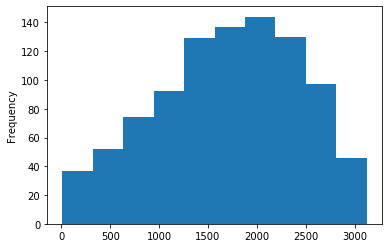

In [209]:
data.MP_league.plot(kind='hist')

In [210]:
# add minimum minutes played
data['min_minutes'] = ((((data['MP_league'] / data['G_league']) + (data['MP_playoff'] / data['G_playoff'])) / 2) > q25).replace({True: 1, False:0})

We also decided to see if dropping players who only played one season would improve our model.

In [211]:
# get rid of players who only played one season
s = data.Player.value_counts() == 1
new = data.set_index('Player', drop=False)
new = data.loc[[True for name in new.Player if name in s]]

## Final Model
---

For our final model, we used the improved model and did a search (using Grid Search) for the best model and parameters using the KNNClassifier().

In [212]:
from sklearn.model_selection import GridSearchCV

In [204]:
new = new.dropna()
X = new.drop(columns=drop + ['UnderPerformed'], axis=1)
y = new.UnderPerformed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [215]:
# How many combinations are there to search through?

parameters = {
    'n_neighbors': [2,4,5,6,7,9,10,11,12,13,14,15,18,19], 
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan']
}
clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
clf.fit(X_train, y_train)
clf.best_params_

{'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'uniform'}

In [216]:
clf_best = clf.best_estimator_
clf_best

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform')

We found that the best patameter was: {'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'uniform'}.
But was the "best parameter" the only "best choice"?

Below we ploted the histogram of scores across all models.As you can see there were a lot of models that had relatively accuracy. These high values imply there are actually many good model choices; and our model is robust.

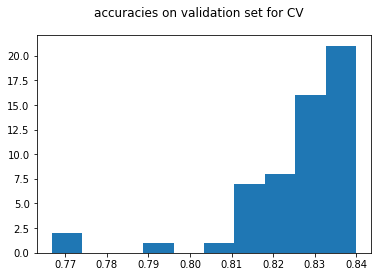

In [217]:
# Each x-value is the score of a different model, corresponding to a choice of parameters

plt.hist(clf.cv_results_['mean_test_score'])
plt.suptitle('accuracies on validation set for CV');

We also plotted the histogram of standard deviations for the CVs. As you can see there were also many small numbers, implying most parameters give stable models.

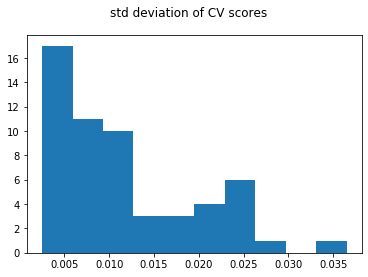

In [218]:
# Each x-value is the standard deviation for the 5-fold CV for a single model, corresponding to a choice of parameters
plt.hist(clf.cv_results_['std_test_score'])
plt.suptitle('std deviation of CV scores');

## Fairness Evaluation
---

In [162]:
# Evaluate your model for "fairness" on an interesting subset of the data using a permutation test. 
# Justify the parity measure you are using.
from sklearn import metrics

In [222]:
perm_data = data.copy()
perm_data.Pos.value_counts()

SG       262
PG       226
SF       198
PF       168
C         73
SF-SG      3
SG-PG      3
SG-SF      2
PF-C       2
PG-SG      1
Name: Pos, dtype: int64

To evaluate our model for fairness, we chose to test demographic parity. After looking at the distribution of 'Position' in the NBA dataset, we noticed that there was an uneven distribution. We chose to run a permutation test to see if the proportion of the population for which a player is classified as 'underperforming'  is the same both within the group, players of position 'PF' (Power Forward), and outside the group.

In [224]:
perm_data['isPF'] = perm_data['Pos'].apply(lambda x: 1 if x == 'PF' else 0)
perm_data.head()

,Player,Pos,Age,Tm,G_league,GS_league,MP_league,FG_league,FGA_league,FG%_league,...,STL_playoff,BLK_playoff,TOV_playoff,PF_playoff,PTS_playoff,Year,%UnderPerformed,UnderPerformed,min_minutes,isPF
1,Arron Afflalo,SG,26.0,DEN,62.0,62.0,2086.0,329.0,699.0,0.471,...,5.0,2.0,9.0,14.0,76.0,2012,-0.107667,1.0,0,0
7,Ray Allen*,SG,36.0,BOS,46.0,42.0,1565.0,226.0,493.0,0.458,...,17.0,2.0,17.0,41.0,192.0,2012,-0.064000,0.0,0,0
8,Tony Allen,SG,30.0,MEM,58.0,57.0,1525.0,210.0,448.0,0.469,...,9.0,7.0,10.0,21.0,48.0,2012,-0.138333,1.0,0,0
14,James Anderson,SG,22.0,SAS,51.0,2.0,603.0,66.0,174.0,0.379,...,1.0,0.0,0.0,1.0,11.0,2012,0.100000,0.0,0,0
15,Ryan Anderson,PF,23.0,ORL,61.0,61.0,1964.0,332.0,757.0,0.439,...,3.0,2.0,9.0,22.0,48.0,2012,-0.115333,1.0,0,1


In [239]:
PF = perm_data[perm_data['isPF'] == 1]
nPF = perm_data[perm_data['isPF'] == 0]

In [242]:
X = PF.drop(columns=drop + ['UnderPerformed'], axis=1)
y = PF.UnderPerformed

pl = Pipeline([('dt', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform'))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pl.fit(X_train, y_train)
print ("Accuracy: %s" % pl.score(X_test, y_test))

Accuracy: 0.7619047619047619


In [243]:
X = nPF.drop(columns=drop + ['UnderPerformed'], axis=1)
y = nPF.UnderPerformed

pl = Pipeline([('dt', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform'))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
pl.fit(X_train, y_train)
print ("Accuracy: %s" % pl.score(X_test, y_test))

Accuracy: 0.8186528497409327


## Inference Analysis:
We chose to test demographic parity because of the distribution of player position. Our permutation test shows that there is no significant difference in the model performance on the different groups, as you can see in the similar accuracy scores.

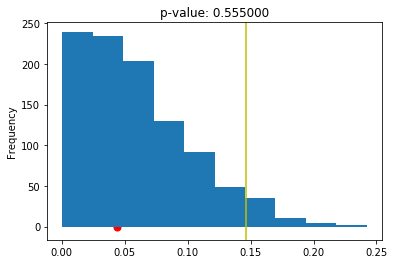

In [238]:
tvds.plot(kind='hist', title='p-value: %f' % pval)
plt.scatter([obs], [0], s=50, color='r')

perc = np.percentile(tvds, 95) # 5% significance level
plt.axvline(x=perc, color='y');